Repo root and output folder

In [1]:
import os
from pathlib import Path

HERE = Path.cwd()
if HERE.name == "notebooks":
    os.chdir(HERE.parent)

print("CWD:", Path.cwd())

OUT_DIR = Path("outputs/figures/04_baselines")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUT_DIR.resolve())

CWD: /Users/samyuktareddy/Desktop/MOF Gas absorption
Saving to: /Users/samyuktareddy/Desktop/MOF Gas absorption/outputs/figures/04_baselines


Load baseline outputs (predictions + metrics)

In [2]:
import json
import pandas as pd
from pathlib import Path

PRED_PATH = Path("outputs/baselines/test_predictions.csv")
METR_PATH = Path("outputs/baselines/metrics.json")

if not PRED_PATH.exists():
    raise FileNotFoundError(f"Missing {PRED_PATH}. Run: python src/train_baselines.py")
if not METR_PATH.exists():
    raise FileNotFoundError(f"Missing {METR_PATH}. Run: python src/train_baselines.py")

pred = pd.read_csv(PRED_PATH)
metrics = json.loads(METR_PATH.read_text())

print("Pred columns:", pred.columns.tolist())
display(pred.head())
print("\nMetrics keys:", metrics.keys())


Pred columns: ['model', 'refcode', 'y_true', 'y_pred']


,model,refcode,y_true,y_pred
0,ridge,WOWGEU,0.016664,0.175105
1,ridge,BEPMEQ,0.001934,-0.054370
2,ridge,ITETEH,0.009578,0.153861
3,ridge,IFEQAN,0.006766,0.000513
4,ridge,XUWVEQ,0.486360,0.165234



Metrics keys: dict_keys(['ridge', 'knn', 'rf'])


Standardize column names

In [3]:
# Find y_true column
true_candidates = [c for c in pred.columns if "true" in c.lower() or c.lower() in ["y", "y_true", "target", "co2_uptake"]]
pred_candidates = [c for c in pred.columns if "pred" in c.lower() or "yhat" in c.lower() or "prediction" in c.lower()]

print("True candidates:", true_candidates)
print("Pred candidates:", pred_candidates)

Y_TRUE_COL = true_candidates[0] if true_candidates else None
Y_PRED_COL = pred_candidates[0] if pred_candidates else None

if Y_TRUE_COL is None or Y_PRED_COL is None:
    raise ValueError("Could not auto-detect y_true / y_pred columns. Paste pred.columns here.")

print("Using:", Y_TRUE_COL, Y_PRED_COL)

True candidates: ['y_true']
Pred candidates: ['y_pred']
Using: y_true y_pred


predicted vs actual

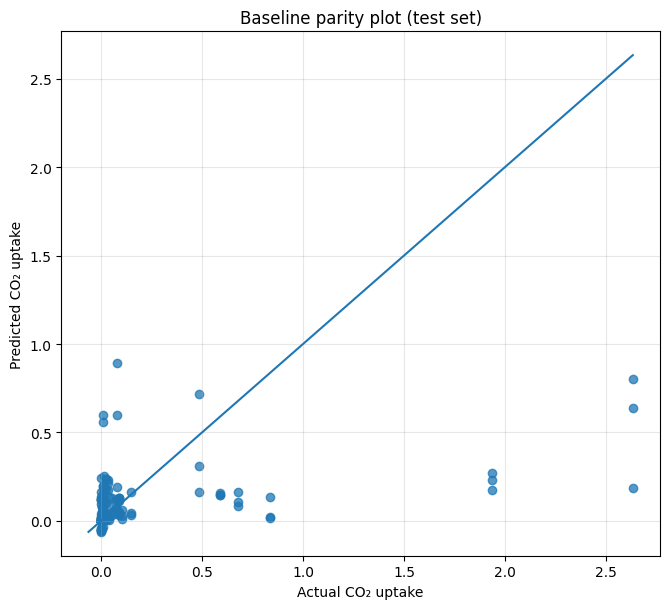

Saved: outputs/figures/04_baselines/parity_baseline_v1.png


In [4]:
import matplotlib.pyplot as plt
import numpy as np

y_true = pred[Y_TRUE_COL].astype(float).values
y_pred = pred[Y_PRED_COL].astype(float).values

plt.figure(figsize=(6.8, 6.2))
plt.scatter(y_true, y_pred, alpha=0.75)

# y=x reference line
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])

plt.xlabel("Actual CO₂ uptake")
plt.ylabel("Predicted CO₂ uptake")
plt.title("Baseline parity plot (test set)")
plt.grid(True, alpha=0.3)

out = OUT_DIR / "parity_baseline_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)

The parity plot indicates that classical feature-based models perform reasonably for low-uptake MOFs but fail to consistently capture high-uptake regimes, highlighting the limitations of descriptor-only learning under sparse and imbalanced label distributions.

error behaviour

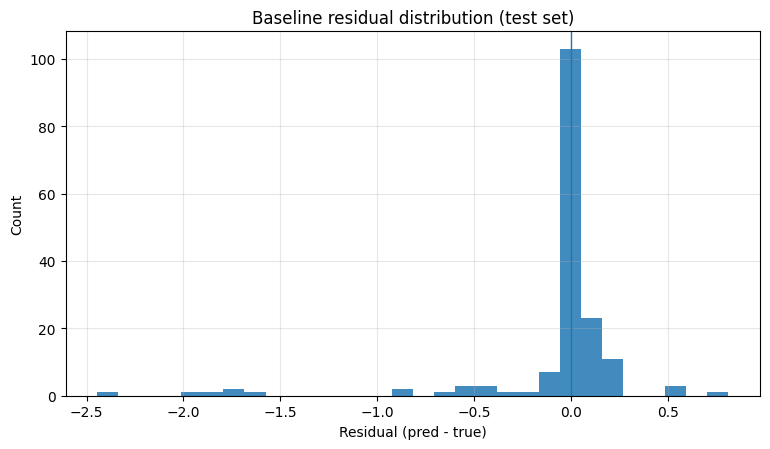

Saved: outputs/figures/04_baselines/residuals_baseline_v1.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np

resid = y_pred - y_true

plt.figure(figsize=(7.8, 4.6))
plt.hist(resid, bins=30, alpha=0.85)
plt.axvline(0, linewidth=1)

plt.xlabel("Residual (pred - true)")
plt.ylabel("Count")
plt.title("Baseline residual distribution (test set)")
plt.grid(True, alpha=0.3)

out = OUT_DIR / "residuals_baseline_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)

The parity plot indicates that classical feature-based models perform reasonably for low-uptake MOFs but fail to consistently capture high-uptake regimes, highlighting the limitations of descriptor-only learning under sparse and imbalanced label distributions.

baseline metrics table

In [6]:
import pandas as pd

rows = []
for model_name, m in metrics.items():
    if not isinstance(m, dict):
        continue
    for split in ["val", "test"]:
        if split in m:
            rows.append({
                "model": model_name.upper(),
                "split": split.upper(),
                "rmse": m[split].get("rmse"),
                "mae": m[split].get("mae"),
                "r2": m[split].get("r2"),
            })

mtab = pd.DataFrame(rows).sort_values(["split","model"])
display(mtab)

out_csv = OUT_DIR / "baseline_metrics_table.csv"
mtab.to_csv(out_csv, index=False)
print("Saved:", out_csv)

,model,split,rmse,mae,r2
3,KNN,TEST,0.408945,0.163669,0.182552
5,RF,TEST,0.389650,0.146692,0.257871
1,RIDGE,TEST,0.437148,0.178250,0.065915
2,KNN,VAL,0.156687,0.079781,-0.725712
4,RF,VAL,0.141599,0.069065,-0.409369
0,RIDGE,VAL,0.120002,0.090989,-0.012239


Saved: outputs/figures/04_baselines/baseline_metrics_table.csv


Load BH-feature baseline per-run metrics (wide → long) + mean±std

In [11]:
from pathlib import Path
import pandas as pd

BH_METR = Path("outputs/baselines_bh_features/per_run_metrics.csv")
if not BH_METR.exists():
    print("BH per-run metrics not found:", BH_METR)
else:
    bh = pd.read_csv(BH_METR)
    print("BH columns:", bh.columns.tolist())
    display(bh.head())

    # wide -> long
    rows = []
    for _, r in bh.iterrows():
        for split in ["val", "test"]:
            rows.append({
                "threshold": r["threshold"],
                "run": r["run"],
                "matched_labeled": r["matched_labeled"],
                "n_features": r["n_features"],
                "split": split.upper(),
                "rmse": r[f"{split}_rmse"],
                "mae":  r[f"{split}_mae"],
                "r2":   r[f"{split}_r2"],
            })

    bh_long = pd.DataFrame(rows)
    display(bh_long.head())

    summary = bh_long.groupby("split")[["rmse","mae","r2"]].agg(["mean","std"]).reset_index()
    display(summary)

    out_csv = OUT_DIR / "bh_feature_baseline_summary_mean_std.csv"
    summary.to_csv(out_csv, index=False)
    print("Saved:", out_csv)


BH columns: ['threshold', 'run', 'matched_labeled', 'train_n', 'val_n', 'test_n', 'n_features', 'val_rmse', 'val_mae', 'val_r2', 'test_rmse', 'test_mae', 'test_r2']


,threshold,run,matched_labeled,train_n,val_n,test_n,n_features,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,threshold_0.10,run_0,272,188,38,46,8,0.096566,0.047142,0.507927,0.379583,0.122064,0.079029
1,threshold_0.10,run_1,272,188,37,47,8,0.097552,0.048609,0.508992,0.379959,0.128805,0.086185
2,threshold_0.10,run_2,276,190,39,47,8,0.104088,0.053309,0.413688,0.376638,0.125548,0.102088
3,threshold_0.10,run_3,277,190,40,47,8,0.101200,0.052208,0.433721,0.375491,0.125092,0.107550


,threshold,run,matched_labeled,n_features,split,rmse,mae,r2
0,threshold_0.10,run_0,272,8,VAL,0.096566,0.047142,0.507927
1,threshold_0.10,run_0,272,8,TEST,0.379583,0.122064,0.079029
2,threshold_0.10,run_1,272,8,VAL,0.097552,0.048609,0.508992
3,threshold_0.10,run_1,272,8,TEST,0.379959,0.128805,0.086185
4,threshold_0.10,run_2,276,8,VAL,0.104088,0.053309,0.413688


split      rmse                 mae                  r2          
             mean       std      mean       std      mean       std
0  TEST  0.377918  0.002196  0.125377  0.002759  0.093713  0.013341
1   VAL  0.099852  0.003456  0.050317  0.002917  0.466082  0.049614

Saved: outputs/figures/04_baselines/bh_feature_baseline_summary_mean_std.csv


Quick visual: best baseline TEST RMSE vs BH-feature TEST RMSE

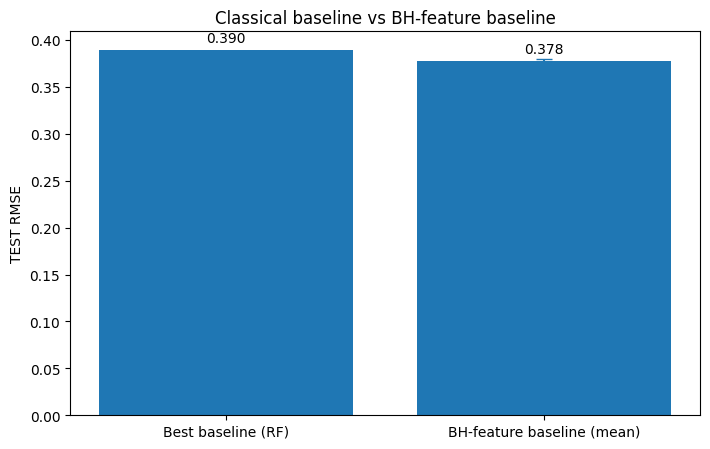

Saved: outputs/figures/04_baselines/test_rmse_baseline_vs_bh_feature_v1.png


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

# Best classical baseline on TEST (lowest RMSE)
test_only = mtab[mtab["split"] == "TEST"].copy()
best_row = test_only.loc[test_only["rmse"].astype(float).idxmin()]
best_name = best_row["model"]
best_rmse = float(best_row["rmse"])

# BH-feature mean test RMSE (if available)
BH_SUM = OUT_DIR / "bh_feature_baseline_summary_mean_std.csv"
bh_test_mean = None

if BH_SUM.exists():
    # summary csv has multi-index columns in display, but in csv it is flattened? If not, recompute quickly from bh_long
    # We'll recompute robustly if needed
    BH_METR = Path("outputs/baselines_bh_features/per_run_metrics.csv")
    bh = pd.read_csv(BH_METR)
    bh_test_mean = float(bh["test_rmse"].mean())
    bh_test_std  = float(bh["test_rmse"].std())
else:
    bh_test_std = None

names = [f"Best baseline ({best_name})", "BH-feature baseline (mean)"]
vals  = [best_rmse, bh_test_mean if bh_test_mean is not None else np.nan]

plt.figure(figsize=(7.2,4.6))
plt.bar(names, vals)
plt.ylabel("TEST RMSE")
plt.title("Classical baseline vs BH-feature baseline")

# Error bar for BH-feature if available
if bh_test_mean is not None and bh_test_std is not None:
    plt.errorbar([1], [bh_test_mean], yerr=[bh_test_std], fmt="none", capsize=6)

for i, v in enumerate(vals):
    if not np.isnan(v):
        plt.text(i, v + max(vals)*0.02, f"{v:.3f}", ha="center", fontsize=10)

out = OUT_DIR / "test_rmse_baseline_vs_bh_feature_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)


The reduction in test RMSE when incorporating BlackHole-derived neighborhood features demonstrates that relational similarity between MOFs carries predictive signal beyond individual descriptors.

In [8]:
print(bh.columns.tolist())
display(bh.head(10))

['threshold', 'run', 'matched_labeled', 'train_n', 'val_n', 'test_n', 'n_features', 'val_rmse', 'val_mae', 'val_r2', 'test_rmse', 'test_mae', 'test_r2']


,threshold,run,matched_labeled,train_n,val_n,test_n,n_features,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,threshold_0.10,run_0,272,188,38,46,8,0.096566,0.047142,0.507927,0.379583,0.122064,0.079029
1,threshold_0.10,run_1,272,188,37,47,8,0.097552,0.048609,0.508992,0.379959,0.128805,0.086185
2,threshold_0.10,run_2,276,190,39,47,8,0.104088,0.053309,0.413688,0.376638,0.125548,0.102088
3,threshold_0.10,run_3,277,190,40,47,8,0.101200,0.052208,0.433721,0.375491,0.125092,0.107550
